# Portfolio Optimisation

A 1/N portfolio with equal weights is amongst portfolio formation strategies like naive diversification, where we select assets because they differ in kind, industry or something else. With this strategy we don't look closely at return or risk, but rather depend on the diversity of our assets.

Other formation strategies do analyse return and risk, and attempt to optimise weights based on some criteria. Portfolio optimisation involves determining the best allocation of our assets to achieve some specific investment objective. Let's optimise our portfolio weights and see what it can do!


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

plt.style.use("ggplot")

RFR = 0.0441
TRADING_DAYS = 252

Above we've got our imports, settings and a constant, and below we've got our data frame being created and checked. We're also selecting the 5 stocks of our portfolio again.

In [2]:
df = pd.read_csv("data/top_six_2020_2025.csv")
df.DlyCalDt = pd.to_datetime(df.DlyCalDt, dayfirst=True)

df_pivot = df.pivot(index="DlyCalDt", columns="Ticker", values="DlyClose")
df_pivot = df_pivot[df_pivot.columns[:5]]

returns = df_pivot.pct_change().dropna()
returns
#df_pivot

Ticker,AAPL,AMZN,GOOGL,META,MSFT
DlyCalDt,,,,,
2020-01-03,-0.009722,-0.012139,-0.005231,-0.005291,-0.012452
2020-01-06,0.007968,0.014886,0.026654,0.018834,0.002585
2020-01-07,-0.004703,0.002092,-0.001932,0.002164,-0.009118
2020-01-08,0.016086,-0.007809,0.007118,0.010138,0.015928
2020-01-09,0.021241,0.004799,0.010498,0.014311,0.012493
...,...,...,...,...,...
2024-12-23,0.003065,0.000622,0.016823,0.024947,-0.003092
2024-12-24,0.011478,0.017729,0.007604,0.013170,0.009374
2024-12-26,0.003176,-0.008732,-0.002601,-0.007240,-0.002777


## Lambdas and Comprehensions

Before we get into optimisation, there are two constructs you'll need to know within Python. These are used all over the language (and in other programming languages as well).

First up we've got `lambda`, or anonymous, functions. If you're in need of a function but don't want to spend time writing one, a lambda function is for you.

In [3]:
# typical def function:
def square_it(x):
    return x ** 2
print(square_it(8)) #outputs the sq of 8 = 64


# ananonymous function:
sq = lambda x: x ** 2

sq(8) # does the same without the need of setting the name/attributes

64


64

Next is **comprehensions**. If lambdas are one-line functions then comprehensions are one-line for loops.


In [4]:
# typical for loop:
l = [] # have to create an empty list 
for i in range(10):
    l.append(i * 2)
print(l) 

# comperahension function:

[i * 2 for i in range(10)] # operation at the beginning and then the for loop, creates the list

[0, 2, 4, 6, 8, 10, 12, 14, 16, 18]


[0, 2, 4, 6, 8, 10, 12, 14, 16, 18]

## Optimise with SciPy

SciPy is a computational library for Python that goes beyond NumPy by adding lots of useful functions for scientific fields. One of the useful functions it has is called `minimize()`, which is used for solving optimisation problems across STEM. This function attempts to minimise some value given a set of input values. In our case, we will be trying to minimise the negative Sharpe Ratio (or maximising the Sharpe Ratio if you prefer!) by finding the optimal portfolio weights.

Recall that Sharpe Ratio is a measure of risk-adjusted return. The higher the value, the higher return we get for the risk we put in.

To work with `minimize()` we need a function. So let's define a function to calculate the negative Sharpe Ratio. It should accept weights as an argument, since this is the parameter we'll be optimising to get the Sharpe Ratio higher.

In [5]:
# opt portoflio by max Sharpe Ratio 
# by changing the weights in the porfolio 

# Scipy works on customised functions

def negative_sharpe(weights): #finding the sharpe ration (need returns -> annual_r and annual_v)
    p_returns = np.dot(returns, weights)

    annualised_returns = p_returns.mean() * TRADING_DAYS
    annualised_volatility = p_returns.std() * np.sqrt(TRADING_DAYS)
    
    SharpeRatio = (annualised_returns - RFR) / (annualised_volatility)

    return -SharpeRatio #since we are going to use minimise function, we need the negative of the SR


Then we need to define the **bounds** and **constraints**, and the *intial weights*.

The bounds restrict the values that `minimize()` will attempt to use for individual inputs (weights in our case). We'll need five weights, and weights should be greater than or equal to 0 and less than or equal to 1.

The constraints restrict the possible solutions that `minimize()` can return. For example, in our solution, all the weights must sum to 1.0, such that our portfolio is complete. 

For the initial weights we'll start with a 1/N portfolio.

In [ ]:
#our constraint is that the weights should add up to 1.00 

constrain = {"type" : "eq", "fun": lambda x: sum(x) - 1 } #set the type to eq => eqals,
# then specify the actual constrain (using fun=>function),
# which fun in fact is lmbda dunction where all weights added up are eqaul to 1 (1-1 = 0)

bounds = tuple((0,1) for x in range(5)) 
#first (0,1) shows the minimum and maximum it can assing for waights,
# then the range of how many securities we have aka 5 (using comperhansion)

init_weights = np.ones(5) / 5 # static weights

optimal = minimize(negative_sharpe, init_weights, bounds=bounds, constraints=constrain)
#atr1 = function we try to min, #atr2 = initial weights, #bounds (min/max per weight), #constrain

opt_weights = optimal.x
opt_weights * 100

array([69.42264188,  0.        , 19.71748081, 10.55310628,  0.30677103])

## Backtesting Optimal Weights

We now have the weights that maximise the Sharpe Ratio. Let's use these weights to see how our portfolio would have performed historically.

### Exercise: Watch your back

Use the `optimal_weights` to calculate new portfolio returns, and daily volatility. How do these annualised values compare to the 1/N portfolio we started with?

In [7]:
## CALCULATING OPTIMAL PORTFOLIO RETURNS AFTER OPTIMISATION

opt_p_returns = np.dot(returns, opt_weights)


Next, plot the optimal weight portfolio cumulative returns and the initial equal weight cumulative returns together on a plot to see how we did compared to the benchmark.

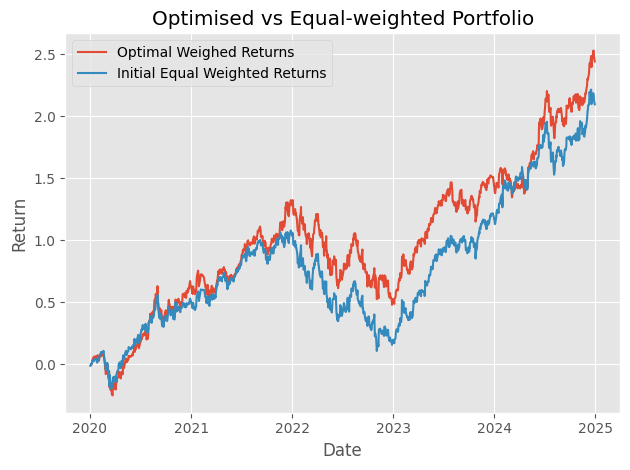

In [8]:
## PLOTING OPTIMAL PORTFOLIO

# against equal weight benchmark portfolio

init_p_returns = np.dot(returns, init_weights)
init_p_returns # unfortinatly no dates atached to our list + missing the first line as no returns there
dates = df_pivot.index[1:] # missing the first line as no returns on first day so remove it

#cumulatative returns on the two protfolios (optimal v initial)
cumul_opt_returns = (1 + opt_p_returns).cumprod() - 1
cumul_init_returns = (1 + init_p_returns).cumprod() - 1

#ploting:
plt.plot(dates, cumul_opt_returns, label="Optimal Weighed Returns")
plt.plot(dates, cumul_init_returns, label="Initial Equal Weighted Returns")
plt.legend()
plt.title("Optimised vs Equal-weighted Portfolio")
plt.xlabel("Date")
plt.ylabel("Return")
plt.tight_layout()

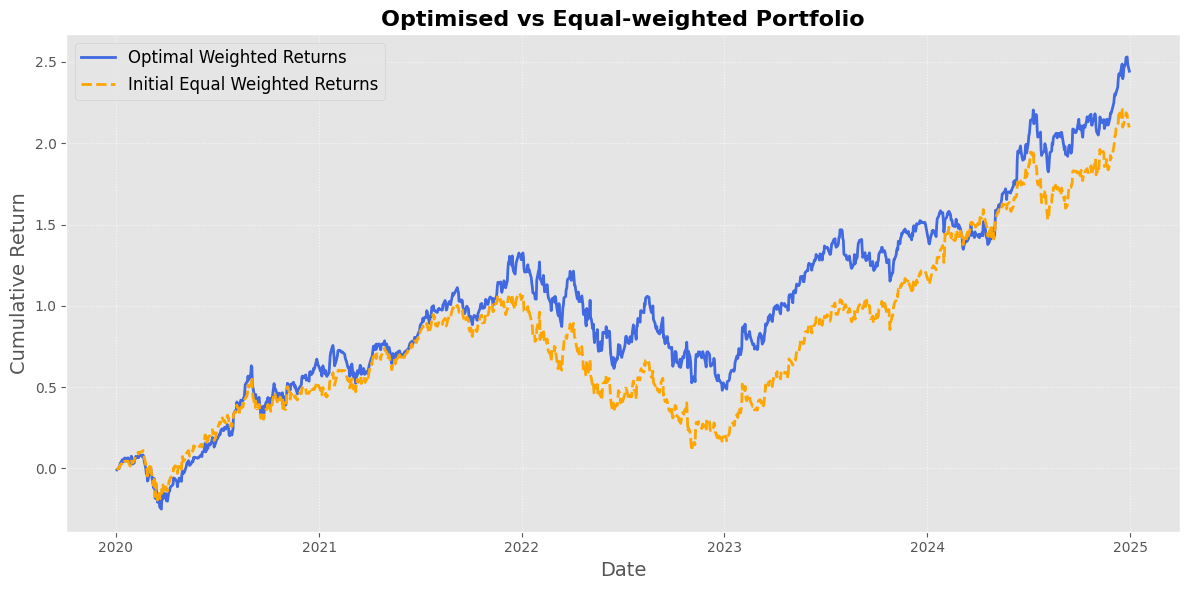

In [9]:
#ploting it with COPILOT, mark the original code, and press "command + i" -> then ask it to make it nicer

plt.figure(figsize=(12, 6))
plt.plot(dates, cumul_opt_returns, label="Optimal Weighted Returns", linewidth=2, color='royalblue')
plt.plot(dates, cumul_init_returns, label="Initial Equal Weighted Returns", linewidth=2, color='orange', linestyle='--')
plt.legend(fontsize=12)
plt.title("Optimised vs Equal-weighted Portfolio", fontsize=16, fontweight='bold')
plt.xlabel("Date", fontsize=14)
plt.ylabel("Cumulative Return", fontsize=14)
plt.grid(True, linestyle=':', alpha=0.7)
plt.tight_layout()
plt.show()

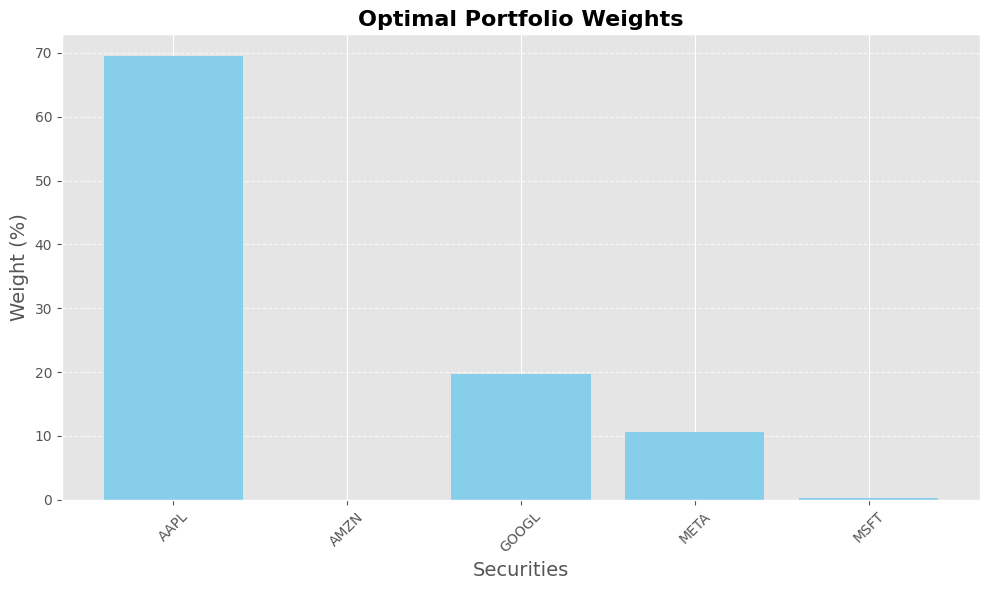

In [10]:
# Create a graph of the optimal weights (to use copilot to create )

plt.figure(figsize=(10, 6))
plt.bar(df_pivot.columns, opt_weights * 100, color='skyblue')
plt.title("Optimal Portfolio Weights", fontsize=16, fontweight='bold')
plt.xlabel("Securities", fontsize=14)           
plt.ylabel("Weight (%)", fontsize=14)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()  